# PubMed Topic Tracker
## 2. Content analyser

This tool allows to analyse the trends of entities over time from a .csv file containing pubmed entries. It takes as input a dataset (i.e: a folder containing a PubMed export generated with the first notebook of this collection, its metadata and the Medline file). 

It outputs a set of .csv files and .svg plots with the trends of keywords, MeSH terms, authors, lemmas in Title/Abstract, amount of COI statements, and lemma trends in COI statements. The .csv files can then be explored further with the third notebook of this collection (interactive data analysis).

Dependencies:
- pandas 1.2.1
- IPython 7.19.0
- tqdm 4.55.1
- matplotlib 3.3.3
- spacy 2.3.5 (+ en_core_web_md)
- wordcloud 1.8.1

In [1]:
# Import libraries
import collections
import pandas as pd
import urllib3
http = urllib3.PoolManager()
from IPython.display import clear_output, Markdown
from tqdm import tqdm
import time
from collections import Counter
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
import spacy
import en_core_web_md
from wordcloud import WordCloud


# Spacy additional configuration
stoplist = ["|", "nan", "background", "introduction"]
nlp = en_core_web_md.load()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp.max_length = 100000000


In [2]:
### Functions

# print in markdown
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
# create dataframe
def create_entity_dataframe(dic2, target_column):
    global df_all_status
    df_all_status = ""
    # Count instances
    countdic = {}
    for key, value in dic2.items():
        counter = Counter(dic2[key])
        c_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
        c_df = c_df.rename(columns={"index": target_column, 0: "count"}) # Specify the name of the columns
        countdic[key] = c_df
    # Check if empty
    empty_list = []
    for key, value in countdic.items():
        empty_list.append(value.empty)
    status = all(x == True for x in empty_list)
    if status == True:
        df_all_status = "empty"
        return("The dataframe is empty. Bummer.")

    else:
        # All of this to one dataframe
        valuelist = []
        keylist = []
        for key, value in countdic.items():
            valuelist.append(value)
            keylist.append(key)

        L = []
        for x in valuelist:
            x = x.set_index(target_column) # Specify the name of the column
            L.append(pd.Series(x.values.tolist(), index=x.index))
        df_all = pd.concat(L, axis=1, keys=(keylist))
        df_all = df_all.fillna('0')
        for x in df_all:
            df_all[x]= df_all[x].str[0]
        df_all = df_all.astype('int')
        indexes = [x for x in range(len(yearlist))]

        sums = df_all.iloc[:, indexes].sum(axis=1)
        df_all = pd.concat([df_all, sums], axis = 1)
        df_all = df_all.rename(columns={0: "total"})
        ### Add descriptive statistics
        # Calculate the min
        mins = df_all.iloc[:, indexes].min(axis=1) 
        df_all = pd.concat([df_all, mins], axis = 1)
        df_all = df_all.rename(columns={0: "min"})

        # Calculate the std
        stds = df_all.iloc[:, indexes].std(axis=1) 
        df_all = pd.concat([df_all, stds], axis = 1)
        df_all = df_all.rename(columns={0: "std"})
        df_all["std"] = (df_all["std"].astype('float')).round(2)

        # Calculate the mean
        means = df_all.iloc[:, indexes].mean(axis=1) 
        df_all = pd.concat([df_all, means], axis = 1)
        df_all = df_all.rename(columns={0: "mean"})
        df_all["mean"] = (df_all["mean"].astype('float')).round(2)

        # Calculate the max
        maxs = df_all.iloc[:, indexes].max(axis=1) 
        df_all = pd.concat([df_all, maxs], axis = 1)
        df_all = df_all.rename(columns={0: "max"})

        # Reorder and reindex
        df_all = df_all.sort_values(by=['total'], ascending=False)
        df_all = df_all.reset_index()
        df_all.index += 1
        filename = target_column.capitalize()
        df_all.to_csv(exportdir + "/data/" + filename + ".csv",  sep=';') # Specify the name of the file
        return df_all

# create normalized dataframe
def create_normalized_dataframe(df_all, target_column):
    df_all_norm = df_all
    df_all_norm = df_all_norm.drop(columns = ["min", "std", "mean", "max", "total"])
    for label, content in papercount.items():
        df_all_norm[label] = df_all_norm[label]/content
    df_all_norm = df_all_norm.fillna(0)

    # Calculate the total
    indexes = []
    for x in range(len(yearlist)):
        indexes.append(x)
    sums = df_all_norm.iloc[:, indexes].sum(axis=1)
    df_all_norm = pd.concat([df_all_norm, sums], axis = 1)
    df_all_norm = df_all_norm.rename(columns={0: "total"})

    # Calculate the min
    mins = df_all_norm.iloc[:, indexes].min(axis=1) 
    df_all_norm = pd.concat([df_all_norm, mins], axis = 1)
    df_all_norm = df_all_norm.rename(columns={0: "min"})

    # Calculate the std
    stds = df_all_norm.iloc[:, indexes].std(axis=1) 
    df_all_norm = pd.concat([df_all_norm, stds], axis = 1)
    df_all_norm = df_all_norm.rename(columns={0: "std"})
    #df_all_norm["std"] = (df_all_norm["std"].astype('float')).round(2)

    # Calculate the mean
    means = df_all_norm.iloc[:, indexes].mean(axis=1) 
    df_all_norm = pd.concat([df_all_norm, means], axis = 1)
    df_all_norm = df_all_norm.rename(columns={0: "mean"})
    #df_all_norm["mean"] = (df_all_norm["mean"].astype('float')).round(2)

    # Calculate the max
    maxs = df_all_norm.iloc[:, indexes].max(axis=1) 
    df_all_norm = pd.concat([df_all_norm, maxs], axis = 1)
    df_all_norm = df_all_norm.rename(columns={0: "max"})

    # Reorder and reindex
    df_all_norm = df_all_norm.sort_values(by=['total'], ascending=False)
    df_all_norm = df_all_norm.reset_index()
    df_all_norm.index += 1
    del df_all_norm['index']
    filename = target_column.capitalize()
    df_all_norm.to_csv(exportdir + "/data/" + filename + "_norm.csv",  sep=';') # Specify the name of the file
    return df_all_norm

# Plot 5 most frequent entities in the dataframe
    # organizing and plotting data
def plot_df_top(df_all, target_column, wordlist, plot_title):
    colnames = list(df_all.columns) 
    colnames = ([x for x in colnames if x.startswith('df_')])
    years = [int(x.replace("df_", "")) for x in colnames]
    df_all_p = df_all.set_index(target_column)
    plotthis = {}
    for x in wordlist:
        servicelist = []
        for y in colnames:
            value = df_all_p.at[x,y]
            servicelist.append(value)
        plotthis[x] = servicelist
    for key, value in plotthis.items():
        lab = key
        x = years
        y = value
        plt.plot(x, y, label = lab)

    # style
    plt.style.use('seaborn')  
    # naming the x axis 
    plt.xlabel('Year', fontsize=15) 
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlim(year0, year1) 
    # naming the y axis 
    plt.ylabel('Count', fontsize=15)
    plt.yticks(fontsize=12)
    # title 
    plt.title(plot_title, fontsize=20)  
    # legend
    plt.legend(fontsize=15) 
    # size
    plt.rcParams["figure.figsize"] = (25,8)
    # save and show the plot 
    plt.savefig(exportdir + "/plots/" + plot_title + ".svg")
    plt.show()

# Plot percentage/count variations
# This function expect a df with two rows (count and percent); a title, and either "count" or "percent"
    # organizing and plotting data
def plot_variations(df_all, plot_title, entity):
    import matplotlib.axes as ax
    colnames = list(df_all.columns) 
    colnames = ([x for x in colnames if x.startswith('df_')])
    years = [int(x.replace("df_", "")) for x in colnames]
    values = []
    for y in colnames:
        value = df_all.at[entity, y]
        values.append(value)
    plt.plot(years, values, label = entity)

    # style
    plt.style.use('seaborn')  
    # naming the x axis 
    plt.xlabel('Year', fontsize=15) 
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    # naming the y axis 
    plt.ylabel(entity.capitalize(), fontsize=15)
    plt.yticks(fontsize=12)
    # title 
    plt.title(plot_title + " - " + entity, fontsize=20)  
    # legend
    plt.legend(fontsize=15) 
    # size
    plt.rcParams["figure.figsize"] = (25,8)
    # save and show the plot 
    plt.savefig(exportdir + "/plots/" + plot_title + " - " + entity + ".svg")
    plt.show()
    
# Spacy preprocessing functions
def is_token_allowed(token):
    if (not token or not token.string.strip() or token.is_stop or token.is_punct or token in spacy_stopwords):
        return False
    return True

def preprocess_token(token):
    if is_token_allowed:
        return token.lemma_.strip().lower()

# Font to use for word clouds
font = "fonts/Roboto-Regular.ttf"
# Function to generate word cloud. expects: dataframe to use, column with entities, column with frequencies, maximum number of words to display, background color
def generate_wordcloud(df, column_entities, column_numbers, m_words, bg_color):
    lemmalist = df[column_entities].tolist()
    freqlist = df[column_numbers].tolist()
    zip_iterator = zip(lemmalist, freqlist)
    freq_dict = dict(zip_iterator)
    wordcloud = WordCloud(width=1000, height=500, background_color = bg_color, font_path = font, min_font_size = 8, max_words=m_words, relative_scaling=1, normalize_plurals=False).generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # save and show the plot 
    plt.savefig(exportdir + "/word clouds/" + "word cloud" + " - " + column_entities + ".svg")
    plt.show()

## Importing the dataframe
Here we create a dataframe importing the .csv of a pre-existing export generated with the first notebook of this collection.

If you want to re-run your analysis on existing data, you can restart from here, no need to re-download the data.

In [3]:
# Create list of datasets
dirlist = []
dircontent = os.listdir("export")
for x in dircontent:
    if x.startswith(".") == False:
        dirlist.append(x)
i = 0
datalist = collections.defaultdict(list)
for x in dirlist:
    if "index" not in datalist:
        datalist["index"] = [i]
    else:
        datalist["index"].append(i)
    i = i+1
    if "dirname" not in datalist:
        datalist["dirname"] = [x]
    else:
        datalist["dirname"].append(x)

    filepath = "export/" + x + "/" + "log.txt"
    with open (filepath, "r") as f:
        file = f.read()
    year0 = re.search(r"(?<=year0\s=\s\")\d*", file)
    year0 = year0.group(0)
    if "year0" not in datalist:
        datalist["year0"] = [year0]
    else:
        datalist["year0"].append(year0)
    year1 = re.search(r"(?<=year1\s=\s\")\d*", file)
    year1 = year1.group(0)
    if "year1" not in datalist:
        datalist["year1"] = [year1]
    else:
        datalist["year1"].append(year1)
    keywords = re.search(r"(?<=keywords\s=\s\").*(?=\")", file)
    keywords = keywords.group(0)
    if "query" not in datalist:
        datalist["query"] = [keywords]
    else:
        datalist["query"].append(keywords)
    paper_count = re.search(r"(?<=paper_count_no_duplicates\s=\s\")\d*", file)
    paper_count = paper_count.group(0)
    if "paper_count" not in datalist:
        datalist["paper_count"] = [paper_count]
    else:
        datalist["paper_count"].append(paper_count)
    querydatetime = re.search(r"(?<=executed\sat:\s).*", file)
    querydatetime = querydatetime.group(0)
    if "querydatetime" not in datalist:
        datalist["querydatetime"] = [querydatetime]
    else:
        datalist["querydatetime"].append(querydatetime)
df_data = pd.DataFrame.from_dict(datalist)
df_data = df_data.drop(df_data.columns[0], axis=1)
pd.set_option('max_colwidth', 500)
df_data.index += 1 
printmd("\n\n## Datasets available: ", color = "black")
display(df_data)
pd.reset_option('max_colwidth')


<span style='color:black'>

## Datasets available: </span>

,dirname,year0,year1,query,paper_count,querydatetime
1,20210329-104455,2010,2020,organ transplantation AND ethics,2034,2021.03.29-09:54:03
2,20220303-215132,2021,2022,xml,51,2022.03.03-21:50:49
3,20210329-112955,1988,2021,"""grappa""[All Fields] AND alcohol[All Fields] NOT psoriasis[All Fields]",29,2021.03.29-11:29:11


In [4]:
dataset = input("specify the dirname of the dataset you want to work with:")
file = "export/" + dataset + "/" + "log.txt"
with open (file, "r") as f:
    file = f.read()
year0 = re.search(r"(?<=year0\s=\s\")\d*", file)
year0 = year0.group(0)
year1 = re.search(r"(?<=year1\s=\s\")\d*", file)
year1 = year1.group(0)
years = []
for x in range (int(year0),int(year1)+1):
    years.append(x)
keywords = re.search(r"(?<=keywords\s=\s\").*(?=\")", file)
keywords = keywords.group(0)
paper_count = re.search(r"(?<=paper_count_no_duplicates\s=\s\")\d*", file)
paper_count = paper_count.group(0)
exportdir = re.search(r"(?<=exportdir\s=\s\").*(?=\")", file)
exportdir = exportdir.group(0)

# check for subfolders and in case create them
if "data" not in os.listdir(exportdir):
    os.mkdir(exportdir + "/data")
    print("data folder created")
if "plots" not in os.listdir(exportdir):
    os.mkdir(exportdir + "/plots")
    print("plots folder created")
if "word clouds" not in os.listdir(exportdir):
    os.mkdir(exportdir + "/word clouds")
    print("word cloud folder created")
querydatetime = re.search(r"(?<=executed\sat:\s).*", file)
querydatetime = querydatetime.group(0)
print("\nUsing dataset: \"" + dataset + "\"\n")
print("Time interval: " + year0 + " - " + year1 + "\n" + "Query: " + keywords + "\n" + "Query date: " + querydatetime + "\n" + paper_count + " entries")

# Create the dataframe
imported_df = pd.read_csv(exportdir + "/PubMed full records.csv", sep=';', low_memory=False) 
imported_df = imported_df.drop(imported_df.columns[0], axis=1)
imported_df.index += 1 

printmd("Showing the first 20 entries of the dataframe", color = "black")
display(imported_df.head(20))

# Export the clean dataframe (removing years outside the query)
#imported_df.to_csv(exportdir + "/PubMed full records_years outside query removed.csv",  sep=';')


specify the dirname of the dataset you want to work with: 20210329-104455



Using dataset: "20210329-104455"

Time interval: 2010 - 2020
Query: organ transplantation AND ethics
Query date: 2021.03.29-09:54:03
2034 entries


<span style='color:black'>Showing the first 20 entries of the dataframe</span>

,p_id,pid_type,year,journal,publisher,title,book_title,abstract,oabstract,authors,editors,language,meshterms,keywords,coi,grant,doi
1,21520559,Article,2010.0,Cirugia pediatrica : organo oficial de la Soci...,NaN,[Need of hepatic bipartition or split in the t...,NaN,AIM: To analyze the benefits of Split (for adu...,NaN,"Andres AM, Lopez Santamaria M, Burgos L, Herna...",NaN,spa,"['Adult', 'Child, Preschool', 'Hepatectomy/*me...",NaN,NaN,NaN,NaN
2,21443156,Article,2010.0,Medicinski pregled,NaN,Cadaveric organ transplantation and religion.,NaN,Multiple organ procurement is a surgical proce...,NaN,"Vukovic M, Moljevic N, Katanic N, Krivokuca D,...",NaN,eng,"['*Brain Death', 'Humans', '*Religion and Medi...",NaN,NaN,NaN,NaN
3,21353967,Article,2010.0,Revue de pneumologie clinique,NaN,[Ethical contradictions in lung transplantation].,NaN,Medical and scientific rationality often overl...,NaN,Sicard D,NaN,fre,"['Humans', 'Lung Transplantation/*ethics']",NaN,NaN,NaN,10.1016/j.pneumo.2010.12.002
4,21183963,Article,2010.0,Nefrologia : publicacion oficial de la Socieda...,NaN,[Assessment and selection of kidney living don...,NaN,Donor protection should always be taken accoun...,NaN,"Gentil Govantes MA, Pereira Palomo P",NaN,spa,"['Algorithms', 'Donor Selection/*methods', 'Hu...",NaN,NaN,NaN,10.3265/Nefrologia.pre2010.Nov.10691
5,21183959,Article,2010.0,Nefrologia : publicacion oficial de la Socieda...,NaN,[Ethical aspects of living-donor kidney transp...,NaN,UNLABELLED: Living donor kidney transplantatio...,NaN,Casares M,NaN,spa,"['Algorithms', 'Humans', 'Informed Consent/eth...",NaN,NaN,NaN,10.3265/Nefrologia.pre2010.Nov.10687
6,21315284,Article,2011.0,Nuclear medicine and biology,NaN,Biological studies in animal models using [99m...,NaN,INTRODUCTION: There are many diseases associat...,NaN,"Teran MA, Martinez E, Reyes AL, Paolino A, Vit...",NaN,eng,"['Animals', '*Annexin A5/chemistry/pharmacokin...",NaN,NaN,NaN,10.1016/j.nucmedbio.2010.08.007
7,21302846,Article,2010.0,American journal of law & medicine,NaN,Can we handle the truth? Legal fictions in the...,NaN,Advances in life-saving technologies in the pa...,NaN,"Shah SK, Miller FG",NaN,eng,"['Advisory Committees', '*Bioethical Issues', ...",NaN,NaN,Intramural NIH HHS/United States,10.1177/009885881003600402
8,21271122,Article,2010.0,Revista da Associacao Medica Brasileira (1992),NaN,[Borderline donors in liver transplantation].,NaN,NaN,NaN,NaN,NaN,por,"['Age Factors', 'Hepatitis B/transmission', 'H...",NaN,NaN,NaN,10.1590/s0104-42302010000600004
9,21265290,Article,2010.0,"Progress in transplantation (Aliso Viejo, Calif.)",NaN,Stranger donors: a key link in transplant chains.,NaN,Living donation to strangers is a complex issu...,NaN,"Veys CG, Bramstedt KA",NaN,eng,"['Adult', 'Altruism', 'Blood Group Incompatibi...",NaN,NaN,NaN,10.7182/prtr.20.4.v80gh271u37j175x
10,21196904,Article,2010.0,Minerva medica,NaN,Ethical models in bioethics: theory and applic...,NaN,Policies for allocating organs to people await...,NaN,Petrini C,NaN,eng,"['Bioethical Issues/*standards', 'Decision Mak...",NaN,NaN,NaN,NaN


## Dividing dataframes by year
Here we divide the big dataframe in many dataframes, one per year, so that we can confront frequencies over time. 

### IMPORTANT: queries might yield articles with dates outside the upper limit of the time range (discrepancies between acceptance and publication date in PubMed can happen). that's why I retrieve the years from the data instead than using them from the query.


In [5]:
df = imported_df
year_list = df['year'].fillna("removethis")
year_list = year_list.tolist()
year_list = [x for x in year_list if x != "removethis"]
year0 = int(year0)
year1 = int(year1)
x = range(int(year0), int(year1) + 1 )
df["year"] = df["year"].astype('Int64')
yearlist = []
querylist = []
for n in x:
    n = "df_" + str(n)
    yearlist.append(n)
for n in x: 
    n = "year == " + str(n)
    querylist.append(n)

# create dictionary of dataframes
d = {}
for x, y in zip(yearlist,querylist):
    d[x] = df.query(y) 

# count papers for normalization
papercount = {}
for key, value in d.items():
    x = len(value.index)
    papercount[key] = x

## Notes on normalization
Normalization is performed in the same whay for each entity, i.e:  normalized entity = count of entity / number of papers. So a normalized value of 0.1 for, e.g. a keyword means that said entity is present in 10% of the entries in the subset. This is true for keywords, MeSH terms and authors, but not for anything which is based on lemmas. More details on this later.

---
## Keyword trends
Here we compute the trends for all the keywords in the dataset. The trends are exported to .csv files. The software plots the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,keywords,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,ethics,0,0,1,12,18,23,17,15,7,17,12,122,0,8.01,11.09,23
2,transplantation,0,0,0,4,14,14,13,6,4,7,12,74,0,5.69,6.73,14
3,organ donation,0,2,0,6,10,7,3,6,6,10,6,56,0,3.48,5.09,10
4,organ transplantation,0,2,1,2,7,5,10,7,6,8,1,49,0,3.39,4.45,10
5,ethics and public policy,0,0,0,0,4,16,9,8,0,0,8,45,0,5.45,4.09,16
6,kidney transplantation,1,0,0,5,6,8,7,7,2,2,2,40,0,3.01,3.64,8
7,brain death,0,0,0,2,3,2,7,3,3,7,7,34,0,2.77,3.09,7
8,organ procurement and allocation,0,0,0,0,3,8,4,4,1,0,5,25,0,2.72,2.27,8
9,organ allocation,0,0,0,1,2,6,4,3,1,1,2,20,0,1.89,1.82,6
10,informed consent,0,1,0,3,2,4,3,0,0,3,0,16,0,1.57,1.45,4


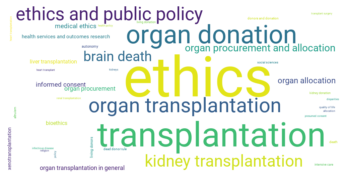

<span style='color:black'>**Plots**</span>

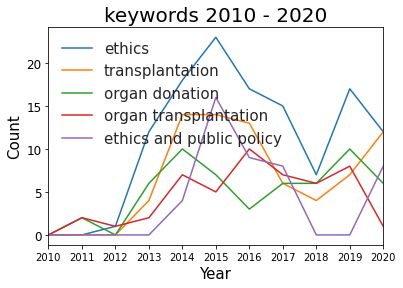

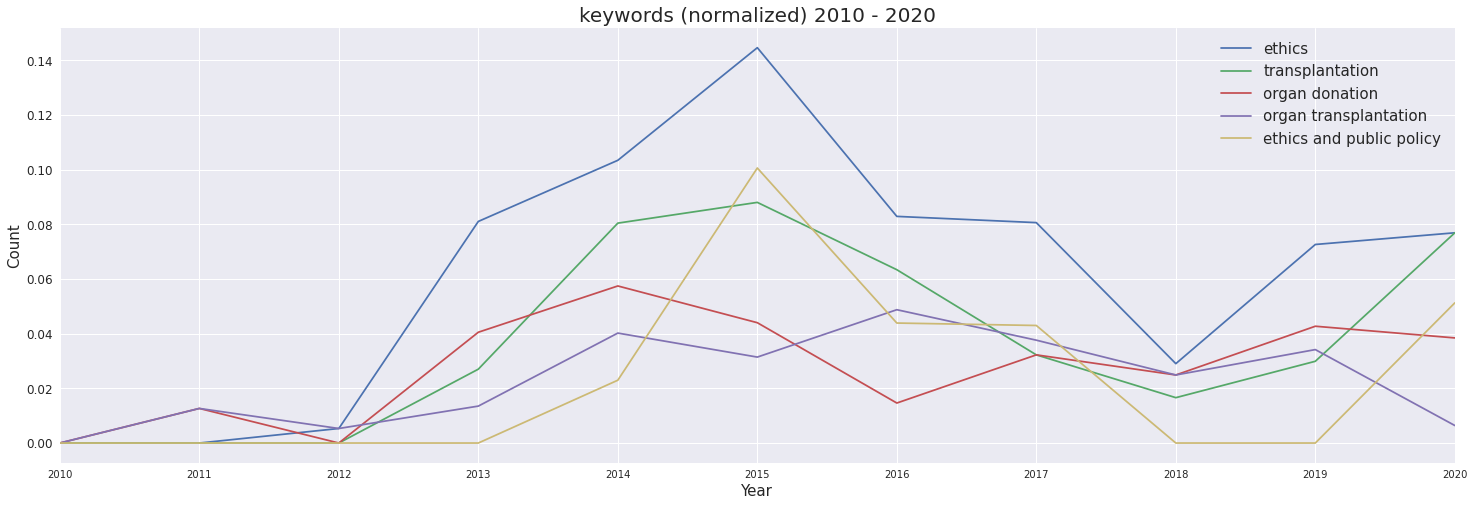

In [6]:
printmd("**Analysis in progress...**", color = "red")

# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
iterable = d.items()
for key, value in tqdm(iterable):
    year_list = []
    listname = "list_" + key
    year_list = value['keywords'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

# Separate objects in the same string (e.g: authors are separated by commas)
typematch = re.compile(r"(?<=')[\w\s]+(?=')")
dic2 = {} # structure: {df_year: [content, but merged]}
for key, value in dic1.items():
    dic2[key] = []
    for x in value:
        x = x.replace("[\'", "\'")
        x = x.replace("\']", "\'")
        x = re.findall(typematch, x)
        for y in x:
            dic2[key].append(y)

# Create the dataframe
df_keywords = create_entity_dataframe(dic2, "keywords")

if df_all_status == "empty":
    print("The keywords dataframe is empty. So no normalization and no plots. Big bummer.")
    keyword_file = exportdir + "/data/Keywords.csv"
    keyword_file_norm = exportdir + "/data/Keywords_norm.csv"
    with open(keyword_file, "w") as empty_csv:
        pass
    with open(keyword_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_keywords_norm = create_normalized_dataframe(df_keywords, "keywords")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_keywords.head(20))

    # Generate word cloud
    generate_wordcloud(df_keywords, "keywords", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    keywords_wordlist = []
    i = 1
    while i < 6:
        word = df_keywords.at[i, "keywords"]
        keywords_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "keywords " + str(year0) + " - " + str(year1)
    plot_df_top(df_keywords, "keywords", keywords_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "keywords (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_keywords_norm, "keywords", keywords_wordlist, title)


---
## MeSH terms trends
Here we compute the trends for all the MeSH terms in the dataset. The trends are exported to .csv files. The software plots the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,meshterms,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,humans,177,153,184,141,169,156,198,178,226,217,92,1891,92,37.16,171.91,226
2,female,34,40,42,38,54,43,46,46,74,73,24,514,24,15.25,46.73,74
3,male,36,37,37,33,48,51,40,48,69,66,21,486,21,14.20,44.18,69
4,adult,26,25,29,31,32,37,23,36,55,49,13,356,13,11.81,32.36,55
5,middle aged,16,20,16,21,31,30,19,24,45,35,12,269,12,9.83,24.45,45
6,united states,43,19,22,17,20,28,26,24,28,30,10,267,10,8.50,24.27,43
7,child,10,9,10,14,11,12,22,13,21,16,6,144,6,4.93,13.09,22
8,aged,8,10,7,12,16,14,9,16,21,17,7,137,7,4.68,12.45,21
9,treatment outcome,6,13,14,10,13,13,10,14,17,17,8,135,6,3.47,12.27,17
10,adolescent,11,7,14,8,11,19,17,13,19,10,4,133,4,4.89,12.09,19


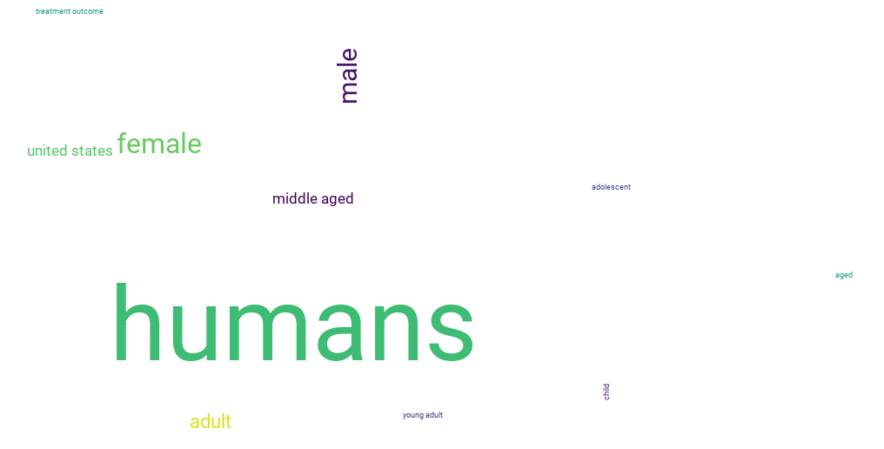

<span style='color:black'>**Plots**</span>

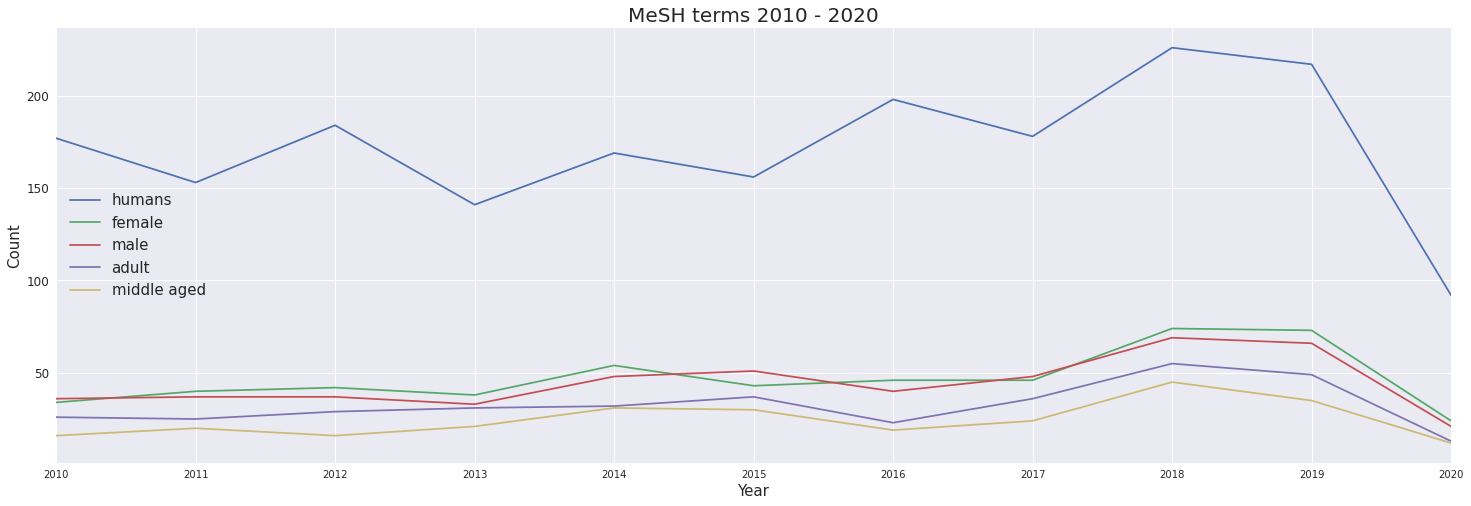

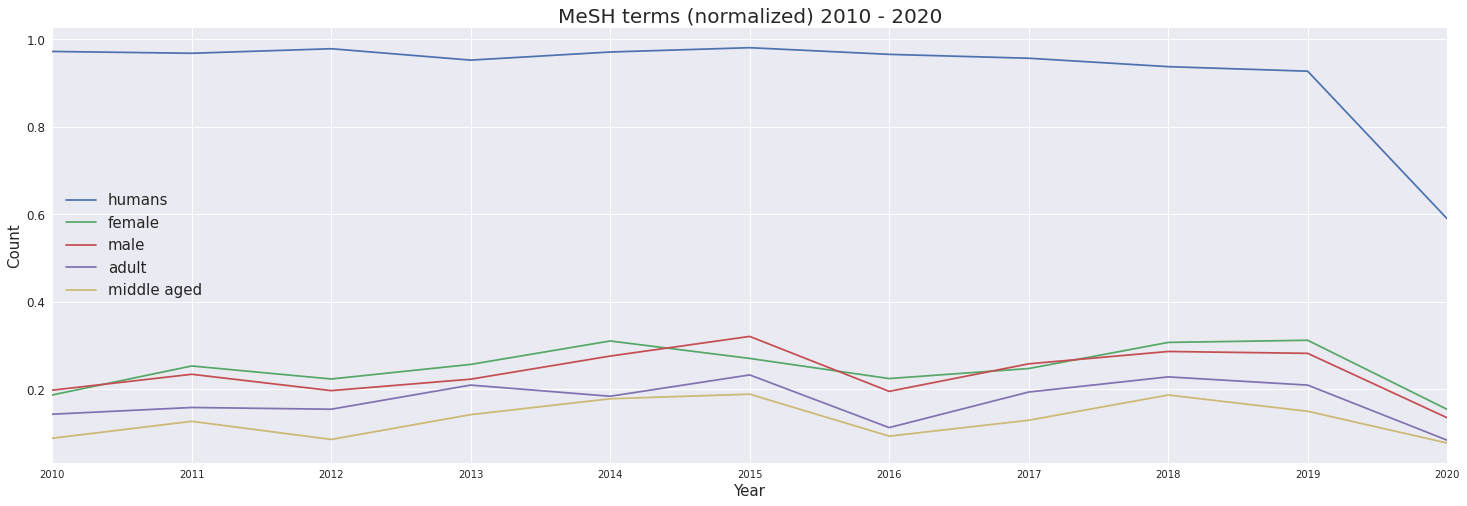

In [7]:
printmd("**Analysis in progress...**", color = "red")

# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
iterable = d.items()
for key, value in iterable:
    year_list = []
    listname = "list_" + key
    year_list = value['meshterms'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

# Separate objects in the same string (e.g: authors are separated by commas)
typematch = re.compile(r"(?<=')[\w\s]+(?=')")
dic2 = {} # structure: {df_year: [content, but merged]}
for key, value in dic1.items():
    dic2[key] = []
    for x in value:
        x = x.replace("[\'", "\'")
        x = x.replace("\']", "\'")
        x = re.findall(typematch, x)
        for y in x:
            dic2[key].append(y)

# Create the dataframe
df_meshterms = create_entity_dataframe(dic2, "meshterms")

if df_all_status == "empty":
    print("The meshterms dataframe is empty. So no normalization and no plots. Big bummer.")
    meshterms_file = exportdir + "/data/Meshterms.csv"
    meshterms_file_norm = exportdir + "/data/Meshterms_norm.csv"
    with open(meshterms_file, "w") as empty_csv:
        pass
    with open(meshterms_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_meshterms_norm = create_normalized_dataframe(df_meshterms, "meshterms")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_meshterms.head(20))

    # Generate word cloud
    generate_wordcloud(df_meshterms, "meshterms", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    meshterms_wordlist = []
    i = 1
    while i < 6:
        word = df_meshterms.at[i, "meshterms"]
        meshterms_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "MeSH terms " + str(year0) + " - " + str(year1)
    plot_df_top(df_meshterms, "meshterms", meshterms_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "MeSH terms (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_meshterms_norm, "meshterms", meshterms_wordlist, title)


---
## Authors trends
Here we compute the trends for all the authors in the dataset. The trends are exported to .csv files. The software plots the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,authors,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,gordon ej,1,2,1,3,1,4,4,3,3,6,2,30,1,1.56,2.73,6
2,reese pp,2,1,1,2,5,3,2,1,4,1,4,26,1,1.43,2.36,5
3,ross lf,3,0,3,0,0,6,4,0,4,3,1,24,0,2.09,2.18,6
4,chapman j,1,1,13,1,2,0,1,0,0,0,0,19,0,3.80,1.73,13
5,segev dl,1,0,2,0,1,1,1,2,4,3,4,19,0,1.42,1.73,4
6,petrini c,1,1,1,4,0,2,1,3,1,4,1,19,0,1.35,1.73,4
7,lavee j,0,2,3,2,2,0,5,1,1,1,1,18,0,1.43,1.64,5
8,ladin k,1,1,0,2,0,1,0,4,2,4,3,18,0,1.50,1.64,4
9,delmonico fl,1,1,3,1,2,4,3,1,1,0,1,18,0,1.21,1.64,4
10,dominguez-gil b,0,1,0,0,1,3,3,2,1,4,3,18,0,1.43,1.64,4


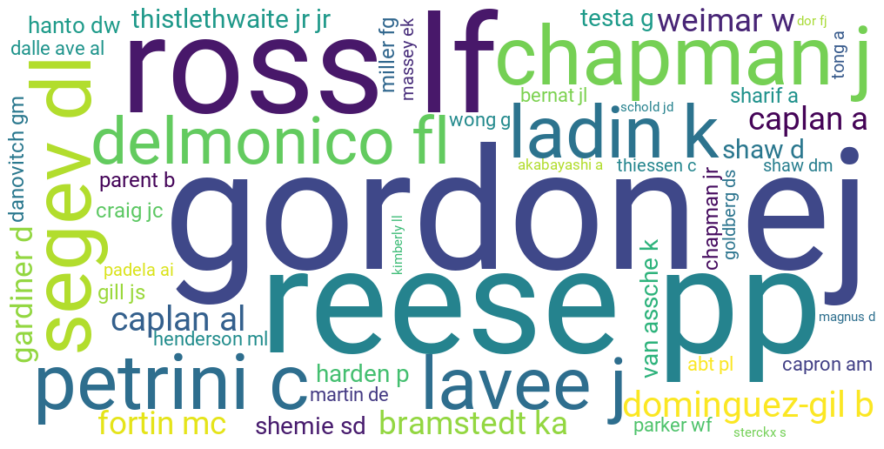

<span style='color:black'>**Plots**</span>

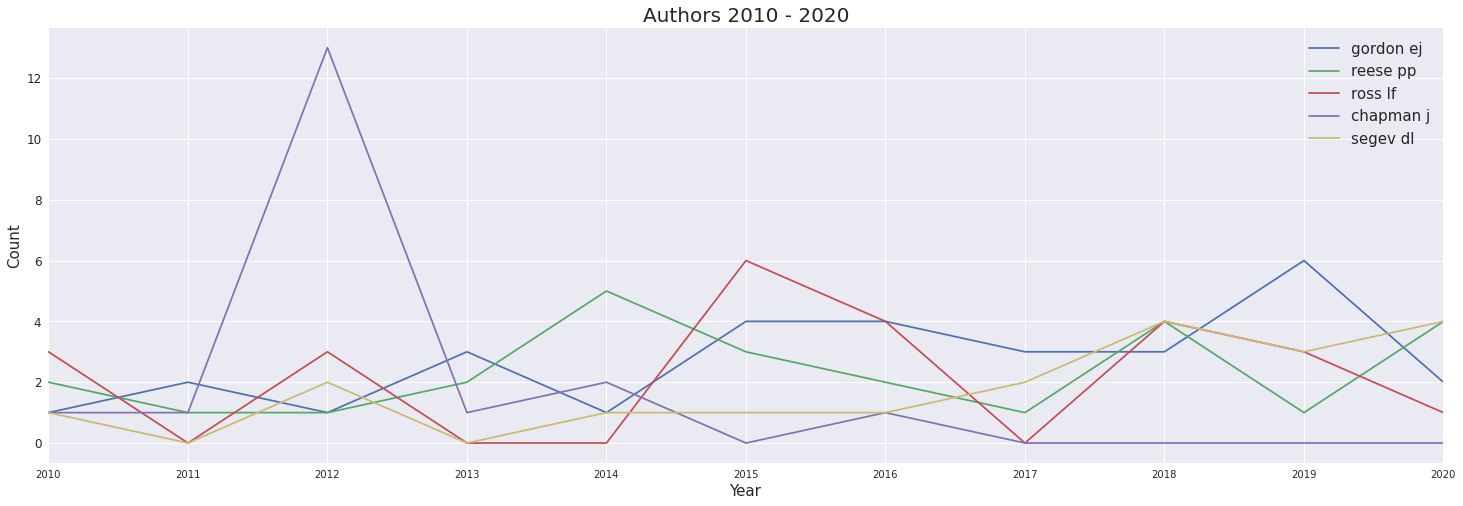

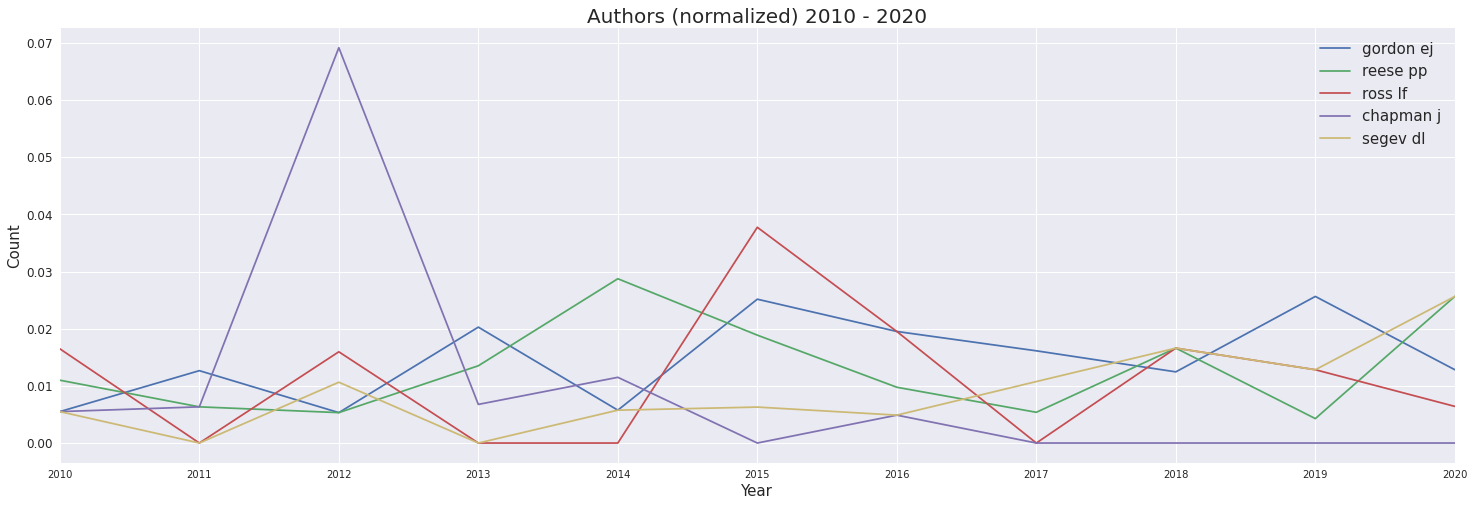

In [8]:
printmd("**Analysis in progress...**", color = "red")

# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
iterable = d.items()
for key, value in tqdm(iterable):
    year_list = []
    listname = "list_" + key
    year_list = value['authors'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

# Separate objects in the same string (e.g: authors are separated by commas)
#typematch = re.compile(r"(?<=')[\w\s]+(?=')") -> not needed for authors, .split is enough
dic2 = {} # structure: {df_year: [content, but merged]}
for key, value in dic1.items():
    dic2[key] = []
    for x in value:
        x = x.split(", ")
        for y in x:
            dic2[key].append(y)

# Create the dataframe
df_authors = create_entity_dataframe(dic2, "authors")

if df_all_status == "empty":
    print("The authors dataframe is empty. So no normalization and no plots. Big bummer.")
    authors_file = exportdir + "/data/Authors.csv"
    authors_file_norm = exportdir + "/data/Authors_norm.csv"
    with open(authors_file, "w") as empty_csv:
        pass
    with open(authors_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_authors_norm = create_normalized_dataframe(df_authors, "authors")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_authors.head(20))

    # Generate word cloud
    generate_wordcloud(df_authors, "authors", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    authors_wordlist = []
    i = 1
    while i < 6:
        word = df_authors.at[i, "authors"]
        authors_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "Authors " + str(year0) + " - " + str(year1)
    plot_df_top(df_authors, "authors", authors_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "Authors (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_authors_norm, "authors", authors_wordlist, title)

---
## *Caveat* : normalization and lemmas
Normalization is performed in the same whay for each entity, i.e:  normalized entity = count of entity / number of papers. So a normalized value of 0.1 for, e.g. a keyword means that said entity is present in 10% of the entries in the subset. This is true for keywords, MeSH terms and authors, but not for anything which is based on lemmas. 

The reason is: any keyword, MeSH term or author can appear maximum once per entry (you don't list twice an author or a keyword). But lemmas can appear more than once per paper, so the normalized values of lemmas should not be considered as percentages.

---
## Lemma trends in title/abstract
Here we compute the trends for all the lemmas in the title/abstract fields. For this purpose we use all the text comprised in the columns "title", "book_title", "abstract", "oabstract". The lemmatization is performed with SpaCy. 
The trends are exported to .csv files. The software plots the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,lemmas,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,organ,323,214,348,307,400,285,363,284,544,534,360,3962,214,101.38,360.18,544
2,donor,262,208,250,243,246,273,351,234,402,348,283,3100,208,59.68,281.82,402
3,transplantation,218,218,301,240,229,210,317,255,393,370,237,2988,210,64.17,271.64,393
4,transplant,193,154,130,192,206,170,242,278,326,426,250,2567,130,85.51,233.36,426
5,donation,198,126,189,173,225,163,235,202,351,299,230,2391,126,63.04,217.36,351
6,patient,151,157,153,153,181,180,240,228,331,328,184,2286,151,67.04,207.82,331
7,live,159,184,178,155,158,194,191,218,312,227,174,2150,155,45.14,195.45,312
8,kidney,136,81,173,138,139,172,165,183,255,179,173,1794,81,42.50,163.09,255
9,ethical,102,89,93,117,134,86,155,116,147,191,117,1347,86,32.14,122.45,191
10,study,49,45,62,77,74,102,103,127,172,174,114,1099,45,44.58,99.91,174


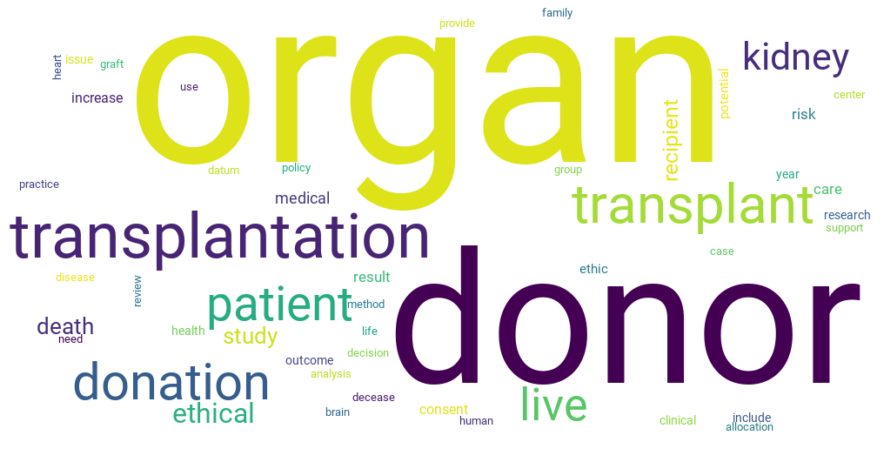

<span style='color:black'>**Plots**</span>

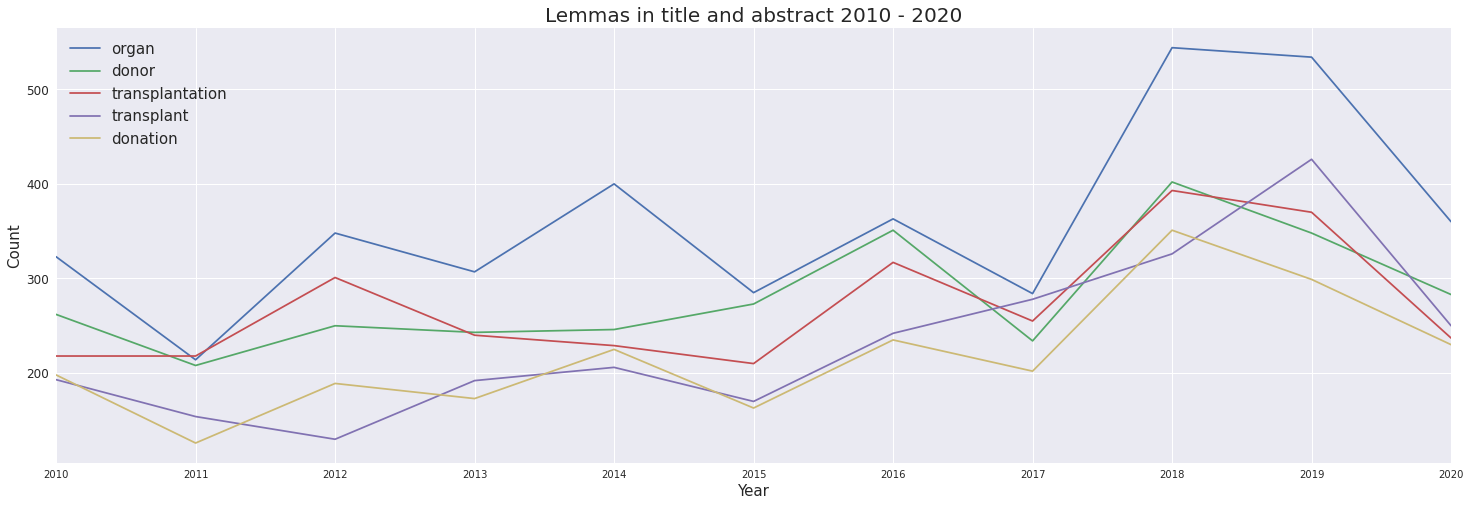

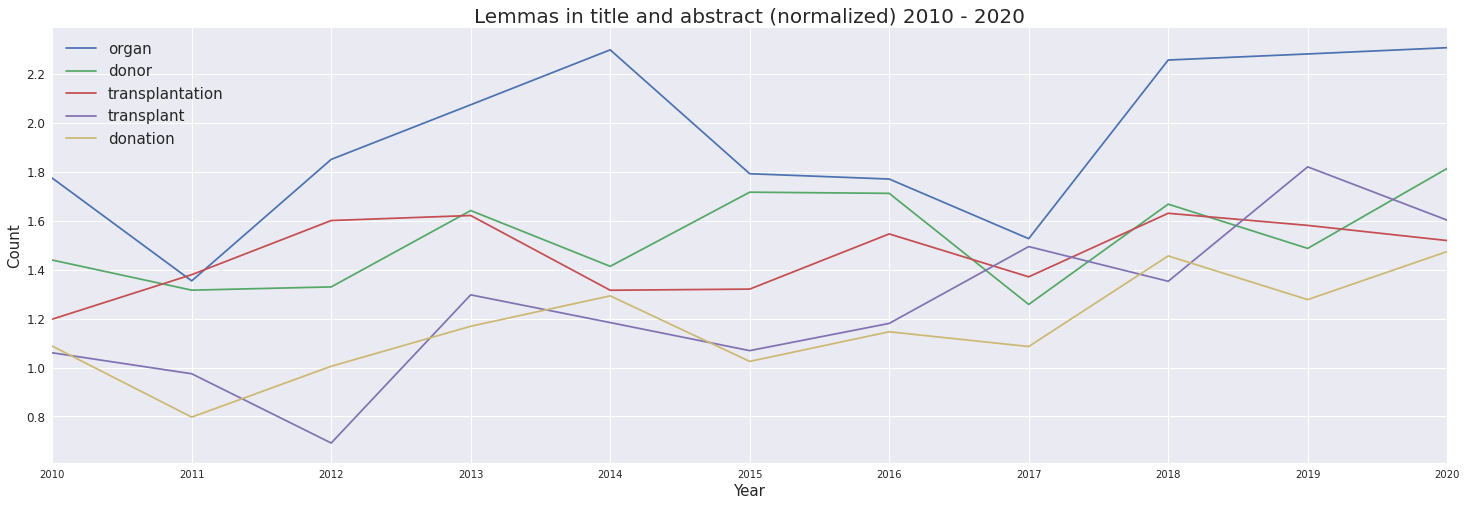

In [9]:
d2 = d
for key, item in d2.items():
    item["text"] = item.title.astype(str) + " | " + item.book_title.astype(str) + " | " + item.abstract.astype(str) + " | " + item.oabstract.astype(str)

# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
for key, value in d2.items():
    year_list = []
    listname = "list_" + key
    year_list = value['text'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

message = "This will take a while. Assuming 10 seconds per iteration, the proces will take about " + str(len(dic1)*10/60) + " minutes. Go grab yourself a coffee."
printmd("\n\n**" + message + "**\n\n", color = "red")

dic2 = {} # structure: {df_year: [content, but processed by spacy]}
iterable = dic1.items()
for key, value in tqdm(iterable):
    text = " ".join(dic1[key])
    file_doc = nlp(text, disable=["tagger", "parser", "attribute_ruler", "ner"]) # disabling some components of the pipeline to speed up
    complete_filtered_tokens = [preprocess_token(token) for token in file_doc if is_token_allowed(token)]
    complete_filtered_tokens = [token for token in complete_filtered_tokens if token not in stoplist]
    dic2[key] = complete_filtered_tokens

# Create the dataframe
df_lemmas = create_entity_dataframe(dic2, "lemmas")

if df_all_status == "empty":
    print("The dataframe is empty. So no normalization and no plots. Big bummer.")
    lemmas_file = exportdir + "/data/Lemmas.csv"
    lemmas_file_norm = exportdir + "/data/Lemmas_norm.csv"
    with open(keyword_file, "w") as empty_csv:
        pass
    with open(keyword_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_lemmas_norm = create_normalized_dataframe(df_lemmas, "lemmas")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_lemmas.head(20))

    # Generate word cloud
    generate_wordcloud(df_lemmas, "lemmas", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    lemmas_wordlist = []
    i = 1
    while i < 6:
        word = df_lemmas.at[i, "lemmas"]
        lemmas_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "Lemmas in title and abstract " + str(year0) + " - " + str(year1)
    plot_df_top(df_lemmas, "lemmas", lemmas_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "Lemmas in title and abstract (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_lemmas_norm, "lemmas", lemmas_wordlist, title)

---
## COI statements and lemma trends in COI
Here we compute the amount of papers that have a COI statement and the trends for all the lemmas in the COI statements. The lemmatization is performed with SpaCy. 
The trends are exported to .csv files. The software plots the presence of COI statements (raw and normalized) and the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

It might be wise to specify an ad-hoc stoplist here, including e.g: "declare", "interest", "compete".

<span style='color:black'>

### COI statements - count</span>

<span style='color:black'>Papers with a COI statement: 132/2034 (6.49%)</span>

,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020
count,0.0,0.0,0.0,0.0,0.0,1.00,5.00,23.00,32.00,39.00,32.00
percent,0.0,0.0,0.0,0.0,0.0,0.63,2.44,12.37,13.28,16.67,20.51


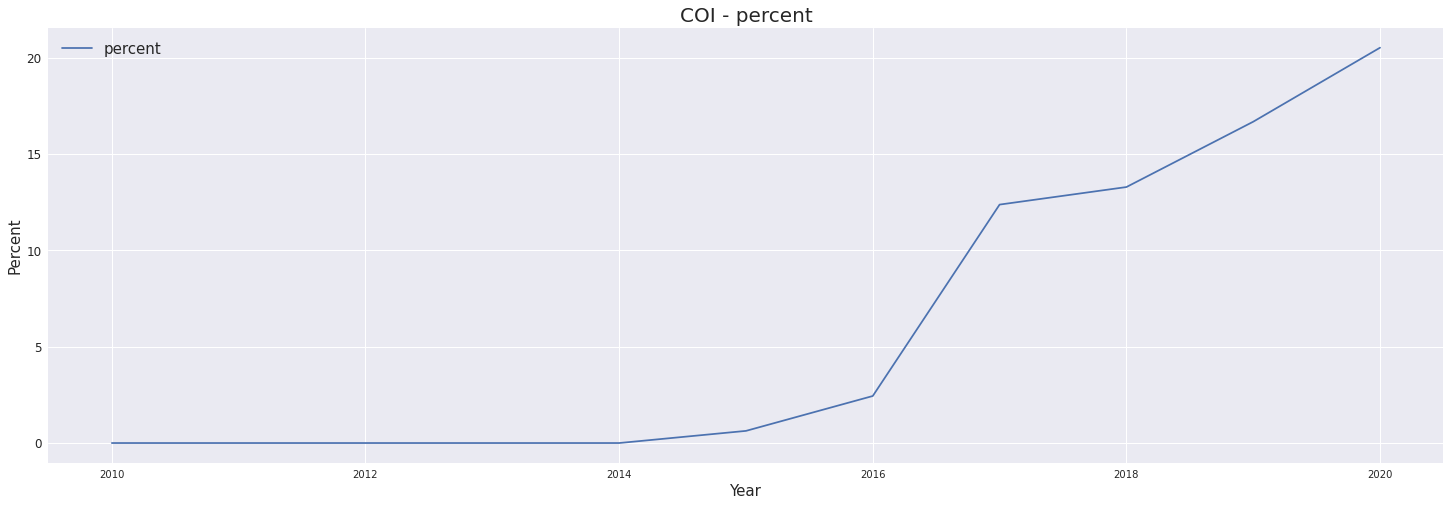

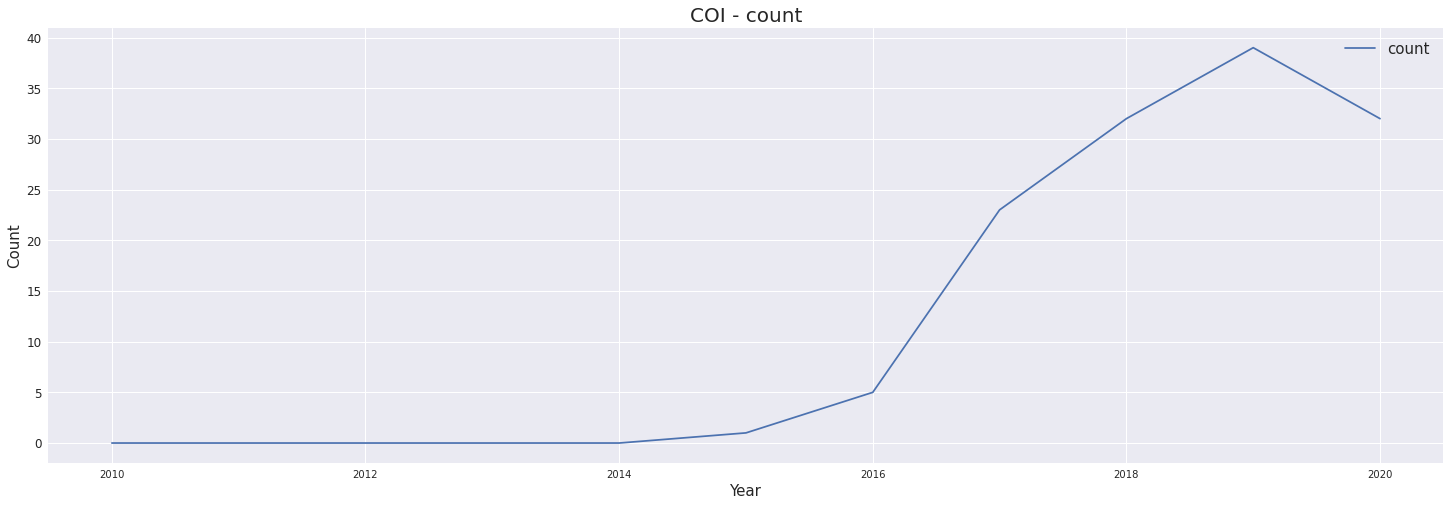

In [10]:
# Amount of COI statements
coi_statements = len(df) - df['coi'].isna().sum()
coi_percent = round(coi_statements/len(df)*100, 2)
printmd("\n\n### COI statements - count", color = "black")
message = ("Papers with a COI statement: " + str(coi_statements) + "/" + str(len(df)) + " (" + str(coi_percent) + "%)")
printmd(message, color = "black")

coi_dict = {}
for key, value in d.items():
    papers_per_year = len(value)
    papers_with_coi = len(value) - value['coi'].isna().sum()
    coi_percent_per_year = round(papers_with_coi/papers_per_year*100, 2)
    line = [papers_with_coi, coi_percent_per_year]
    coi_dict[key] = line
coi_df = pd.DataFrame.from_dict(coi_dict)
coi_df = coi_df.rename(index={0: "count", 1: "percent"})
coi_df = coi_df.fillna(0)
indexes = [i for i in range(0,len(yearlist))]

filename = "Amount of COI statements"
coi_df.to_csv(exportdir + "/data/" + filename + ".csv",  sep=';') # Specify the name of the file
display(coi_df)
plot_variations(coi_df, "COI", "percent")
plot_variations(coi_df, "COI", "count")

<span style='color:black'>

### COI statements - lemmas</span>

<span style='color:black'>
Stoplist:
['|', 'nan', 'background', 'introduction', 'the']</span>

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,coi_lemmas,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,interest,0,0,0,0,0,0,7,24,25,38,38,132,0,15.98,12.00,38
2,declare,0,0,0,0,0,0,3,16,22,30,24,95,0,11.85,8.64,30
3,compete,0,0,0,0,0,0,0,16,17,32,17,82,0,11.17,7.45,32
4,conflict,0,0,0,0,0,0,7,7,14,10,19,57,0,6.78,5.18,19
5,author,0,0,0,0,0,0,4,3,14,6,11,38,0,4.97,3.45,14
6,potential,0,0,0,0,0,0,1,2,2,5,10,20,0,3.12,1.82,10
7,committee,0,0,0,0,0,0,0,2,6,10,1,19,0,3.29,1.73,10
8,research,0,0,0,0,0,0,0,1,3,7,7,18,0,2.80,1.64,7
9,ethic,0,0,0,0,0,0,1,3,7,5,1,17,0,2.42,1.55,7
10,study,0,0,0,0,0,0,1,3,2,6,1,13,0,1.89,1.18,6


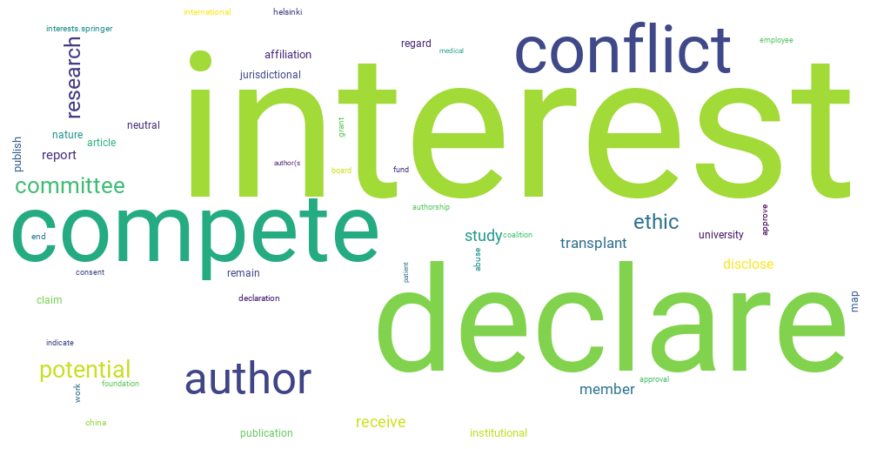

<span style='color:black'>**Plots**</span>

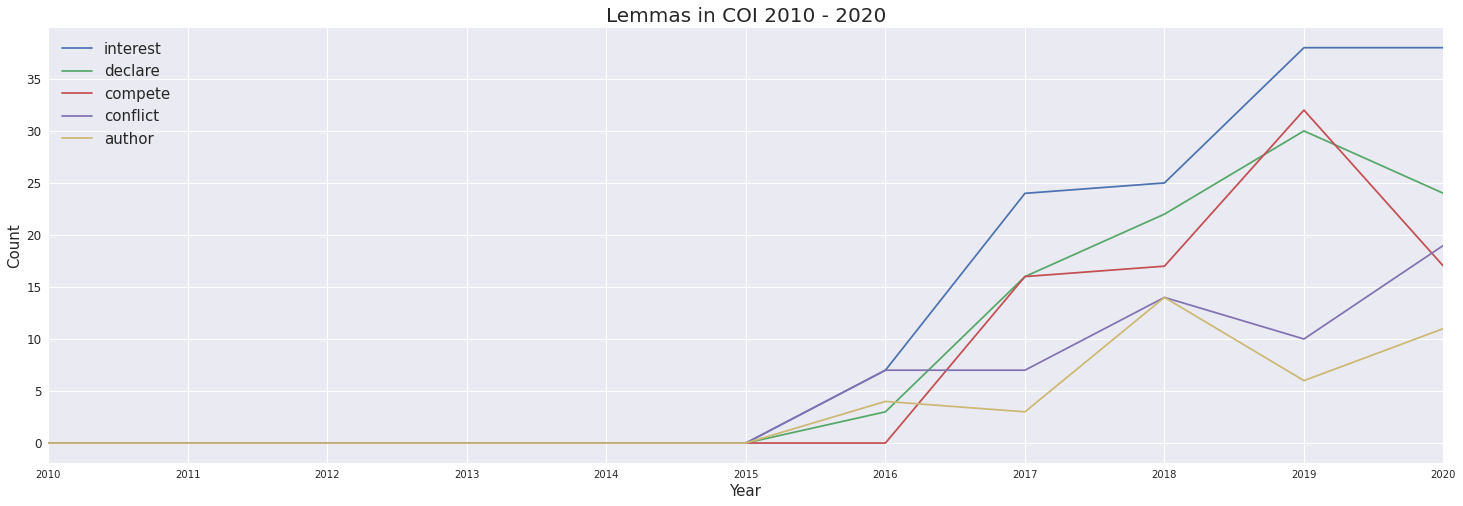

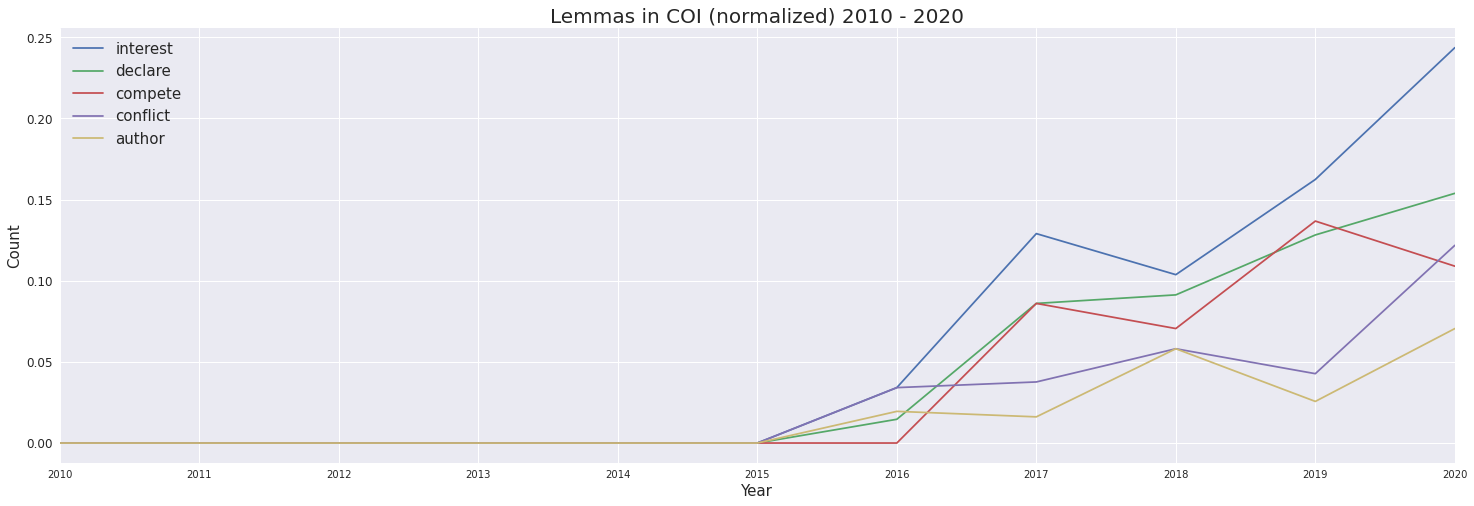

In [11]:
# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
for key, value in d.items():
    year_list = []
    listname = "list_" + key
    year_list = value['coi'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

# Additional stoplist
printmd("Here you can specify some additional stopwords to refine the analysis, excluding frequent tokens that might be relevant for general lemma frequency analysis, but not here, e.g: declare. Separate the words with a comma, or leave empty to keep using the standard stoplist. The list resets each time you run this block of code.", color = "black")
coi_additional_stoplist = input()
coi_additional_stoplist = coi_additional_stoplist.split(", ")
coi_lemma_stoplist = stoplist
for x in coi_additional_stoplist:
    if x not in coi_lemma_stoplist:
        coi_lemma_stoplist.append(x)

message = "This will take a while. Assuming 10 seconds per iteration, the proces will take about " + str(len(dic1)*30/60) + " minutes. Go grab yourself a coffee."
printmd("\n\n**" + message + "**\n\n", color = "red")

dic2 = {} # structure: {df_year: [content, but processed by spacy]}
iterable = dic1.items()
for key, value in tqdm(iterable):
    text = " ".join(dic1[key])
    file_doc = nlp(text, disable=["tagger", "parser", "attribute_ruler", "ner"]) # disabling some components of the pipeline to speed up
    complete_filtered_tokens = [preprocess_token(token) for token in file_doc if is_token_allowed(token)]
    complete_filtered_tokens = [token for token in complete_filtered_tokens if token not in coi_lemma_stoplist]
    dic2[key] = complete_filtered_tokens

# Create the dataframe
df_coi_lemmas = create_entity_dataframe(dic2, "coi_lemmas")

if df_all_status == "empty":
    print("The dataframe is empty. So no normalization and no plots. Big bummer.")
    coi_lemmas_file = exportdir + "/data/Coi_lemmas.csv"
    coi_lemmas_file_norm = exportdir + "/data/Coi_lemmas_norm.csv"
    with open(coi_lemmas_file, "w") as empty_csv:
        pass
    with open(coi_lemmas_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_coi_lemmas_norm = create_normalized_dataframe(df_coi_lemmas, "coi_lemmas")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n### COI statements - lemmas", color = "black")
    printmd("\nStoplist:\n" + str(coi_lemma_stoplist), color = "black")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_coi_lemmas.head(20))

    # Generate word cloud
    generate_wordcloud(df_coi_lemmas, "coi_lemmas", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    coi_lemmas_wordlist = []
    i = 1
    while i < 6:
        word = df_coi_lemmas.at[i, "coi_lemmas"]
        coi_lemmas_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "Lemmas in COI " + str(year0) + " - " + str(year1)
    plot_df_top(df_coi_lemmas, "coi_lemmas", coi_lemmas_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "Lemmas in COI (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_coi_lemmas_norm, "coi_lemmas", coi_lemmas_wordlist, title)

## Journal trends

Here we compute the trends for all the journals in the dataset. The trends are exported to .csv files. The software plots the five most frequent entities in the dataframe. This is basically for reporting; for a more refined analysis use the Data Explorer notebook.

<span style='color:green'>

**Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.**

</span>

<span style='color:black'>**Trends**</span>

,journal,df_2010,df_2011,df_2012,df_2013,df_2014,df_2015,df_2016,df_2017,df_2018,df_2019,df_2020,total,min,std,mean,max
1,american journal of transplantation : official...,11,4,9,4,10,19,33,38,30,33,36,227,4,13.52,20.64,38
2,transplantation,6,8,10,5,11,9,10,12,8,7,7,93,5,2.16,8.45,12
3,journal of medical ethics,4,4,4,6,11,10,10,8,6,8,7,78,4,2.55,7.09,11
4,transplantation proceedings,9,14,7,6,5,7,1,3,6,9,6,73,1,3.38,6.64,14
5,the american journal of bioethics : ajob,12,20,8,0,5,6,2,1,3,1,1,59,0,6.07,5.36,20
6,bmj open,0,0,0,1,0,8,4,10,5,14,8,50,0,4.89,4.55,14
7,bioethics,2,1,2,2,4,3,3,2,10,3,1,33,1,2.49,3.00,10
8,cambridge quarterly of healthcare ethics : cq ...,2,4,3,8,1,0,3,0,4,3,0,28,0,2.38,2.55,8
9,liver transplantation : official publication o...,4,4,1,5,2,5,1,3,2,0,0,27,0,1.86,2.45,5
10,"progress in transplantation (aliso viejo, calif.)",5,2,2,1,3,0,3,4,2,4,1,27,0,1.51,2.45,5


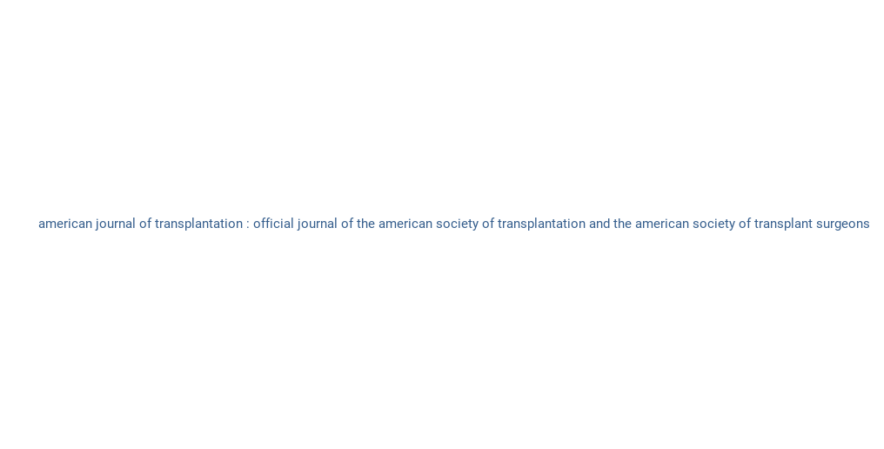

<span style='color:black'>**Plots**</span>

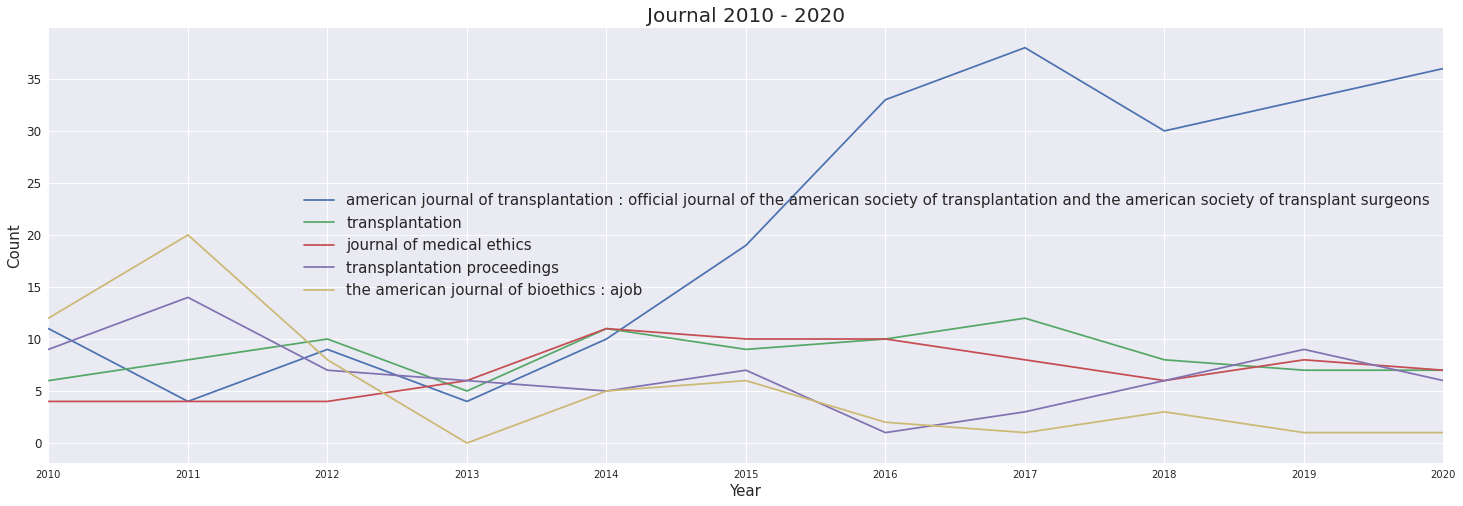

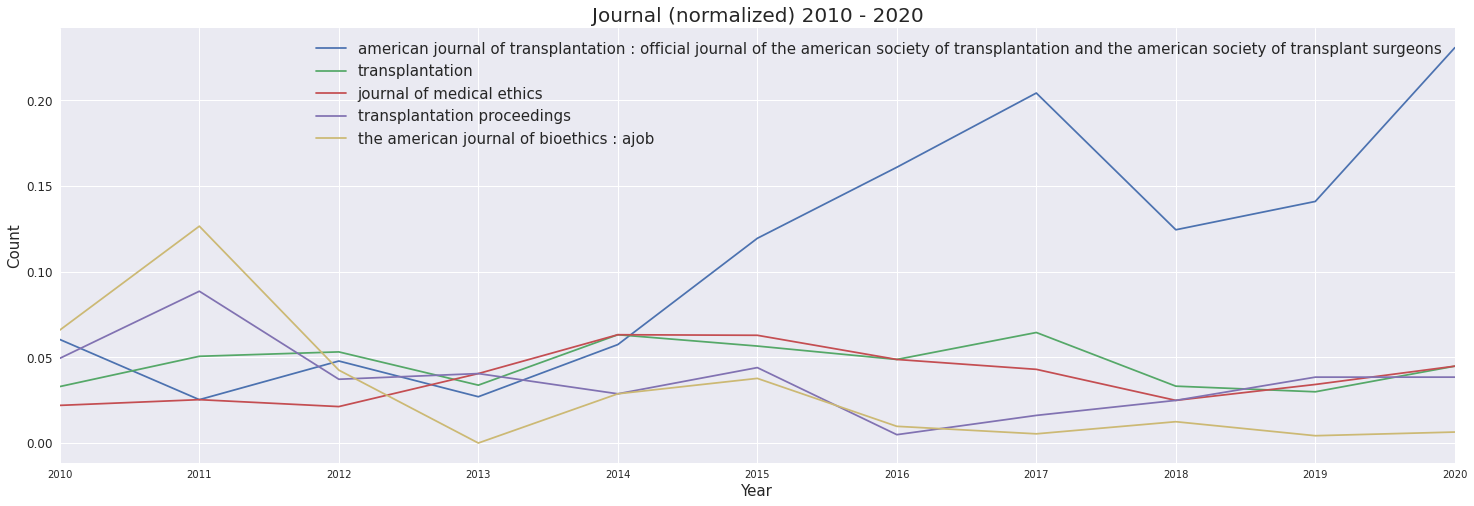

In [12]:
printmd("**Analysis in progress...**", color = "red")

# Retrieve objects divided by year and organize them in a dic {key: [object]}
list_global = []
iterable = d.items()
for key, value in tqdm(iterable):
    year_list = []
    listname = "list_" + key
    year_list = value['journal'].tolist() # -> Configure here the column to target
    year_list = [x.lower() for x in year_list if str(x) != "nan"] # -> All to lowercase to merge duplicates, e.g: "Ethics" and "ethics"
    list_global.append(year_list)
dic1 = dict(zip(yearlist, list_global)) # Structure: {df_year: [content, but divided by entry]}

# Create the dataframe
df_journal = create_entity_dataframe(dic1, "journal")

if df_all_status == "empty":
    print("The journal dataframe is empty. So no normalization and no plots. Big bummer.")
    journal_file = exportdir + "/data/Journal.csv"
    journal_file_norm = exportdir + "/data/Journal_norm.csv"
    with open(journal_file, "w") as empty_csv:
        pass
    with open(journal_file_norm, "w") as empty_csv:
        pass
else:
    # Create the normalized dataframe
    df_journal_norm = create_normalized_dataframe(df_journal, "journal")

    # Display the dataframe
    clear_output()
    message = ("Trends computed. Displaying the trends of the 20 most frequent entities in the dataframe.")
    printmd("\n\n**" + message + "**\n\n", color = "green")
    printmd("**Trends**", color = "black")
    display(df_journal.head(20))

    # Generate word cloud
    generate_wordcloud(df_journal, "journal", "total", 50, "white")

    # Get the list of the entities to plot (5 most common entities in the first dataframe)
    journal_wordlist = []
    i = 1
    while i < 6:
        word = df_journal.at[i, "journal"]
        journal_wordlist.append(word)
        i = i+1

    print("\n\n")
    printmd("**Plots**", color = "black")

    # Plot the data
    title = "Journal " + str(year0) + " - " + str(year1)
    plot_df_top(df_journal, "journal", journal_wordlist, title)

    print("\n\n")

    # Plot the normalized data
    # Important: plotting the same list as above!
    title = "Journal (normalized) " + str(year0) + " - " + str(year1)
    plot_df_top(df_journal_norm, "journal", journal_wordlist, title)